# Build a CV Train/Score/Evaluate Scaffold
* similar benefits to CI/CD pipeline
  * quickly try and validate new ideas
* something to build on top of, e.g. feature selection
* start with ~1/2 of data
  * overfitting will occur--subsetting early mitigates some of this
* store all models and supporting data
* support various models
* bespoke strafified sampling for folds
* plotting routines for evaluation

## TODO
* #### feature importance and contribution
* #### feature and model selection
* move functions to .py files
* save models to disk
* save tables
* save plots
* metrics
* add other evaluations like super contest style pick top 5 --> accuracy

## Boilerplate

### Separate schema: __labels, models, features, cv__

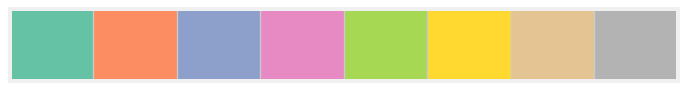

In [1]:
%run initialize.ipynb

import cPickle as pickle
import json

from pyspark.sql import Window

# spark.sql('CREATE SCHEMA labels')
# spark.sql('CREATE SCHEMA models')
# spark.sql('CREATE SCHEMA features')
# spark.sql('CREATE SCHEMA cv')

In [2]:
rcParams['figure.figsize'] = (12,8)
rcParams['figure.dpi'] = 96

## Global Functions

#### CV Functions

In [3]:
def get_cv_data(model_dict):
    '''using model dict, add random seeds, 
    make labels in [0,1], and return only 
    relevant columns'''
    labels_prep = spark.table(model_dict['labels_tbl']).select(
            *( set(model_dict['index']) 
              | set(model_dict['strata_cols']) 
              | set([model_dict['label_col']]) )
        )

    return labels_prep.withColumn(
            'dataset_rnd', F.rand(model_dict['dataset_seed'])
        ).withColumn(
            'dim_rnd', F.rand(model_dict['dataset_seed'])
        ).withColumn(
            'kfold_rnd', F.rand(model_dict['kfold_seed'])
        ).withColumn(
            'label', 
            F.when(
                col(model_dict['label_col']).isin(model_dict['pos_labels']), 
                1
            ).when(
                 col(model_dict['label_col']).isin(model_dict['neg_labels']), 
                0
             ).otherwise(None)
        ).filter(
            col('label').isNotNull()
        )

def prop_dict_rolling(d):
    '''given a dictionary of probabilities, where
    the values are floats that sum to 1, 
    return a dictionary with the same keys, where
    the values are disjoint windows.
    usage note: top is inclusive. bottom is exclusive unless 0.
    usage note: if both elements are the same, skip'''
    rolling_sum = 0
    rolling = {}
    for k,v in d.iteritems():
        rolling[k] = (rolling_sum, rolling_sum+v)
        rolling_sum += v
    return rolling

def modify_group_for_dim(model_dict, df, d, colname):
    '''given a DF with a groups assigned (variable colname),
    apply a dictionary to post-process the groups according 
    to that one dimension. returns original DF with modified
    colname column.
    e.g. move specific seasons to the holdout or throwaway sets.
    '''
    dim_props = model_dict['dimensional_dataset_proportions'].iteritems()
    for grp, grp_dict_list in dim_props:
        for grp_dict in grp_dict_list:
            window = Window.orderBy('dim_rnd')\
                           .partitionBy(grp_dict['dim'], colname)
            df = df.withColumn('dim_rk', F.percent_rank().over(window))

            ## if (1) the column is within the set values,
            ## (2) the pre-existing group falls within those set values, and
            ## (3) the random value is below the set threshold,
            ## then override and modify the group membership
            if grp_dict['prop_to_move'] > 0:
                df = df.withColumn(
                    colname, 
                    F.when(
                        (col(grp_dict['dim']).isin(grp_dict['vals']))
                        & (col(colname).isin(grp_dict['from_groups'])) 
                        & (col('dim_rk') >= 1 - grp_dict['prop_to_move']), 
                      grp
                    ).otherwise(col(colname))
                )
    return df

def assign_k_folds(model_dict, training_rows):
    '''given model dict and pandas DF
    of training data, assign K folds
    using stratified sampling
    '''
    ## assign K folds
    kfolds = model_dict['kfolds']
    if kfolds > 1:
        ## make a mapping from fold --> range of random numbers
        ## e.g. fold 0 --> [0.6, 0.8]
        folds_dict = {k: 1./kfolds for k in np.arange(kfolds)}
        folds_rolling = prop_dict_rolling(folds_dict)
        ## apply mapping
        training_rows = assign_group(
                model_dict, training_rows, folds_rolling, 
                model_dict['strata_cols'], 'fold'
            )
    else:
        ## if kfold == 1, then skip k-fold.
        ## 1 model will be trained using all data in training dataset.
        ## scoring dataset will be scored with that model.
        training_rows = training_rows.withColumn('fold', F.lit(None))
        
    return training_rows

def assign_group(model_dict, df, d, strata_cols, colname):
    '''given (1) a dictionary of ranges,
    (2) a DF with random values ranked 
    by random block, and 
    (3) a name for the grouped columns,
    return DF with a new column that 
    assigns group membership'''
    
    window = Window.orderBy('dataset_rnd')\
                   .partitionBy(*model_dict['strata_cols'])
    df = df.withColumn('dataset_rk', 
                       F.percent_rank().over(window))
    for i, (k,v) in enumerate(d.iteritems()):
        ## if the bottom is 0, make it -1 to include 0
        min_val = -1 if v[0] == 0 else min_val
        if i == 0:
            group_assign_cond = F.when(
                (col('dataset_rk') > min_val)
                & (col('dataset_rk') <= v[1]),
                F.lit(k)
            )
        else:
            group_assign_cond = group_assign_cond.when(
                (col('dataset_rk') > min_val)
                & (col('dataset_rk') <= v[1]),
                F.lit(k)
            )
    
    return df.withColumn(colname, group_assign_cond)

def get_training_scoring_sets(model_dict, training_rows):
    '''given model dict and pandas DF of the rows
    to be used for training, and the folds, 
    return 2 pandas DFs: prepped training and scoring sets'''
    index = model_dict['index']
    features_prep = spark.table(model_dict['features_tbl']).select(
            *( set(model_dict['features_list']) 
               | set(index) )
        )

    training = features_prep.join(
        training_rows.select(*(index + ['label','fold'])),
        on=index
    )
    scoring_only = features_prep.join(
        scoring_rows.select(*(index + ['label'])),
        on=index
    )

    assert training.count() == training_rows.count()
    assert scoring_only.count() == scoring_rows.count() 
    
    return (training, scoring_only)

#### Training/Scoring functions -- TODO: add spark ML functionarlity

In [4]:
def get_model_obj(model_dict):
    '''using the string version of model
    e.g. xgboost.XGBClassifier, load that 
    object leveraging importlib library'''
    import importlib

    model_class_str = model_dict['model']
    model_obj_path = '.'.join(model_class_str.split('.')[:-1])
    model_name = model_class_str.split('.')[-1]
    model_package = importlib.import_module(model_obj_path)
    model_class = getattr(model_package, model_name)
    in_memory = model_class_str.split('.')[0] in ['sklearn','xgboost']
    
    return (model_class, in_memory)

def cv_train(model_dict, training, scoring_only, model_obj):
    '''given training/scoring data, model dict, 
    and a model obj, train k models plus the entire
    dataset and return dict of (set name, fitted model) pairs'''
    training_df = training.toPandas().set_index(model_dict['index'])
    scoring_only_df = scoring_only.toPandas().set_index(model_dict['index'])
    
    ## folds
    if model_dict['kfolds'] > 1:
        training_scoring_dict  = {
            f: {'train': training_df[training_df['fold'] != f],
                'score': training_df[training_df['fold'] == f]}
            for f in np.arange(model_dict['kfolds'])
        }
    else:
        training_scoring_dict = {}
    ## full sets
    training_scoring_dict['full'] = {
        'train': training_df,
        'score': scoring_only_df
    }
    
    feats = sorted(model_dict['features_list'])
    for set_nbr, set_data in training_scoring_dict.iteritems():
        if set_data['train'].shape[0] > 0:
            training_scoring_dict[set_nbr]['model'] = \
                model_obj(
                    **model_dict['model_params']
                ).fit(
                    np.array(set_data['train'][feats].values.tolist()),
                    set_data['train']['label'].ravel()
                )
    return training_scoring_dict
    
def cv_score(model_dict, training_scoring_dict):
    '''takes the model dict and another dict:
    keys are datasets (fold number or "full"),
    values dict with values of
    (training_df, scoring_only, fitted model obj).
    return pandas DF of scores'''
    
    feats = sorted(model_dict['features_list'])
    for i, (set_nbr, mdl) in enumerate(training_scoring_dict.iteritems()):
        curr_scoring = mdl['score']
        if curr_scoring.shape[0] > 0:
            curr_scoring['score'] = mdl['model'].predict_proba(
                                        curr_scoring[feats].values.tolist()
                                    )[:,1]
            if i == 0:
                scores_df = curr_scoring
            else:
                scores_df = scores_df.append(curr_scoring)
    
    return scores_df

#### Plotting functions

In [73]:
def compute_bins(plots_dict, df, nbins, bin_type):
    '''given a pandas DF of scores and labels,
    compute nbins using either percentiles or 
    histogram style bins'''
    
    assert bin_type in ['Bin','Percentile'] 
    
    label_map = plots_dict['label_map']
    ## Bin into nbins bins
    if bin_type == 'Bin':
        df[bin_type] = df['score'].apply(
            lambda x: int(np.round(x*nbins, 0))
        )
    ## Bin by percentile
    elif bin_type == 'Percentile':
        df = df.sort_values(by='score')
        df['rk'] = np.arange(0, df.shape[0], 1)
        df['rk'] /= float(df.shape[0])
        df[bin_type] = df['rk'].apply(
            lambda x: int(np.round(x*nbins, 0))
        )

    scores_to_plot = spark.createDataFrame(df[[bin_type,'label']])

    ## reindex 0,1,2,...,100
    new_idx = np.arange(0, nbins+1, 1)

    return scores_to_plot.groupby(bin_type)\
                         .pivot('label')\
                         .count()\
                         .fillna(0)\
                         .toPandas()\
                         .rename(columns=label_map)\
                         .set_index(bin_type)\
                         .reindex(new_idx)\
                         .fillna(0)\
                         .sort_index()

def compute_plot_bins(plots_dict, df, nbins, bin_type, colors):
    '''given a pandas DF of bins, plot the bins
    overlaid on each other'''
    
    label_map = plots_dict['label_map']
    scores_colors = (colors[0], colors[3], colors[1], colors[2])

    for i, c in enumerate(df.columns.tolist()[::-1]):
        df[c].plot(kind='bar', rot=0, color=scores_colors[i], width=1, 
                   alpha = 0.75 - 0.25*i)
        
    plt.title('Distribution of Scores vs. Labels: Score {}s'.format(bin_type))
    plt.legend()
    plt.ylabel('Count')
    plt.xlabel('Score {}s'.format(bin_type))
    skipticks = int(np.ceil(nbins / 20.))
    a, b = plt.xticks()
    plt.xticks(a[::skipticks], b[::skipticks])
    plt.show()
    
def plot_trend(plots_dict, df, bin_type, nbins):
    import statsmodels.api as sm
    '''given binned pandas DF, and dict defining
    success, return a bar chart of success by score bin
    and trendlines to indicate whether higher scores correlate
    with greater success'''
    
    eval_dict = plots_dict['eval_dict']
    success_col = eval_dict['success_col']
    failure_col = eval_dict['failure_col']
    success_name = eval_dict['success_name']
    df['success'] = df[success_col].astype(float) \
                    / ( df[success_col] + df[failure_col] )

    ax = plt.figure().add_subplot(111)
    ## plot bar chart of win rate by bin
    df['success'].plot(
        kind='bar', color=colors[2], rot=0, alpha = 0.75, ax=ax,
        title='{} By {}'.format(success_name, bin_type), 
        label='Actual {}'.format(success_name)
    )
    
    ## ols method doesn't take columns with sapces
    bin_type_nospace = bin_type.replace(' ','_')
    scores_trend = df.reset_index(drop=False)\
                     .loc[:, [bin_type,'success']]\
                     .rename(columns={ bin_type:bin_type_nospace })
    
    ## Fit OLS model    
    linreg = sm.formula.ols(
        formula='success ~ {}'.format(bin_type_nospace), 
        data=scores_trend
    )
    
    res = linreg.fit()
    scores_trend = scores_trend.assign(OLS=res.fittedvalues)

   ## LOWESS Trends (wider window and tigher window)
    lowess = sm.nonparametric.lowess

    lowess_wide = lowess(
            scores_trend['success'], 
            scores_trend[bin_type_nospace], 
            frac = 2./3
        )
    lowess_tight = lowess(
            scores_trend['success'], 
            scores_trend[bin_type_nospace], 
            frac=1/np.sqrt(nbins)
        )

    ## assign method takes **kwargs in the form of 
    ## new column name: column definition
    scores_trend = scores_trend.assign(
        **{'LOWESS Wide Window': lowess_wide[:,1],
           'LOWESS Tight Window': lowess_tight[:,1]}
    )

    ## plot trendlines
    scores_trend['OLS'].plot(kind='line', ax=ax, color=colors[1])
    scores_trend['LOWESS Wide Window'].plot(
                kind='line', ax=ax, color=colors[0]
            )
    scores_trend['LOWESS Tight Window'].plot(
                kind='line', ax=ax, color=colors[4]
            )
    
    skipticks = int(np.ceil(nbins / 20.))
    plt.legend()
    plt.ylabel(success_name)
    plt.xlabel('Score {}s'.format(bin_type))    
    a, b = plt.xticks()
    plt.xticks(a[::skipticks], b[::skipticks])
    plt.show()

def plot_single_roc_curve(df, tprs, aucs, mean_fpr, i, set_name):
    '''given pandas DF of label and score,
    compute ROC values and add to current plot.
    append appropriate values to trps and aucs'''
    from sklearn.metrics import roc_curve, auc
    from scipy import interp
    
    fpr, tpr, thresholds = roc_curve(df['label'], df['score'])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    _ = plt.plot(fpr, tpr, lw=0.5, alpha=0.5, color=colors[i+1],
             label='ROC {} (AUC = {:.2f})'.format(set_name, roc_auc))
    
def roc_plot_kfold_errband(roc_sets):
    '''plot ROC curves, with curves and AUCs 
    for each of the K folds, the mean curve/AUC, 
    and error band'''
    from sklearn.metrics import auc
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    for i, (set_nbr, df) in enumerate(roc_sets.iteritems()):
        ## plot a single ROC curve
        ## and append to tprs and aucs
        plot_single_roc_curve(
                df, tprs, aucs, mean_fpr, i, 'Fold {}'.format(i)
            )

    ## random (as good as random guessing)
    _ = plt.plot([0, 1], [0, 1], linestyle='--', lw=1, color=colors[-1],
             label='Always Predict Majority Class', alpha=0.8)

    ## compute mean ROC
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    _ = plt.plot(mean_fpr, mean_tpr, color=colors[0],
             label=r'Mean ROC (AUC = {:.2f} $\pm$ {:.2f})'.format(mean_auc, std_auc),
             lw=2, alpha=.8)

    ## add error bands, +/- 1 stddev
    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    _ = plt.fill_between(
        mean_fpr, tprs_lower, tprs_upper, color=colors[-1], 
        alpha=0.2, label=r'$\pm$ 1 std. dev.'
    )

    ## modify plot attributes
    _ = plt.xlim([-0.05, 1.05])
    _ = plt.ylim([-0.05, 1.05])
    _ = plt.xlabel('False Positive Rate')
    _ = plt.ylabel('True Positive Rate')
    _ = plt.title('ROC Curve')
    _ = plt.legend(loc="lower right")
    plt.show()

def plot_by_threshold(df, metric):
    '''given a pandas DF of scores, 
    compute and plot the accuracy, 
    given score thresholds
    0.00,0.01,0.02,...,1.00'''
    from sklearn.metrics import f1_score, accuracy_score
    
    acc_curve = {}
    for i in np.arange(0, 1.01, 0.01):
        df['pred'] = (df['score'] >= i).astype(int)
        
        if metric == 'Accuracy':
            acc_curve[i] = accuracy_score(df['label'], df['pred'])
        elif metric == 'F1':
            acc_curve[i] = f1_score(df['label'], df['pred'])

    acc_df = pd.DataFrame\
               .from_dict(acc_curve, orient='index')\
               .sort_index()\
               .rename(columns={0:metric})
    acc_df.index.name = 'Model Score'

    peak = acc_df.loc[acc_df.idxmax()]
    peak_score = peak.index[0]
    peak_acc = peak.iloc[0,0]
    x0_50_acc = acc_df.loc[0.50, metric]

    _ = acc_df.plot(
        kind='line', 
        title='{} at Different Classification Thresholds'.format(metric)
    )
    _ = plt.axhline(
        y=peak_acc, xmin=0, xmax=1, 
        label='Score {:.3f} | {} {:.3f} (Peak)'
                  .format(peak_score, metric, peak_acc),
        linewidth=2, color=colors[2]
    )
    _ = plt.axhline(
        y=acc_df.loc[0.50, metric], xmin=0, xmax=1, 
        label='Score 0.50 | {} {:.3f}'.format(metric, x0_50_acc),
        linewidth=2, color=colors[3]
    )
    _ = plt.legend()
    _ = plt.ylabel(metric)

In [72]:
res
linreg

NameError: name 'res' is not defined

## Generate quick and dirty features/labels sets for testing purposes 

In [6]:
## SPREAD
ranks = spark.table('dvoa').select(
        'team_id','season','week_id','dave_or_wtddvoa',
        'offensedvoa','defensedvoa','s_t_dvoa'
    ).cache()
game_feats = spark.table('labels.team_game_line_labels').select(
        'game_id','season','week_id','team_id','is_home'
    ).cache()

features = game_feats.join(
        ranks, on=['team_id','season','week_id']
    )
labels = spark.table('labels.team_game_line_labels').select(
    ## index
    'game_id','team_id',
    ## strata
    'is_home','is_fav_sbr',
    ## labels
    'did_win','final_margin','did_cover_pfr',
    'did_cover_sbr','did_cover_sbr_open'
)

assert features.count() == labels.count()

features.write.mode('overwrite').saveAsTable('features.0109_test')
labels.write.mode('overwrite').saveAsTable('labels.0109_test')

## OVER/UNDER
features = spark.table('labels.over_under_labels').select(
        'game_id','season','week_id', 'sbr_ou'
    ).cache()

labels = spark.table('labels.over_under_labels').select(
    ## index
    'game_id',
    ## strata
    ## label
    'is_sbr_ou_over'
)

assert features.count() == labels.count()

features.write.mode('overwrite').saveAsTable('features.0111_ou_test')
labels.write.mode('overwrite').saveAsTable('labels.0111_ou_test')

## Parameters dictionaries

### Won/Lost

In [8]:
model_dict = {
    'model_id': '0111_did_win_initial',
    'features_tbl': 'features.0109_test',
    'labels_tbl': 'labels.0109_test',
    'features_list': [
        'season',
        'week_id',
        'is_home',
        'dave_or_wtddvoa',
        'offensedvoa',
        'defensedvoa',
        's_t_dvoa'
    ],
    'label_col': 'did_win',
    'pos_labels': [1],
    'neg_labels': [-1],
    'index': ['game_id','team_id'],
    'kfolds': 5,
    'kfold_seed': 99,
    'dataset_seed': 9,
    'strata_cols': ['did_win','is_home'],
    'global_dataset_proportions': {
        'holdout': 0.5,
        'throw_away': 0,
        'in_training': 0.5,
        'scoring_only': 0
    },
    'dimensional_dataset_proportions': {
    'throw_away': [{
        'dim': 'is_home',
        'from_groups': ['in_training','holdout','scoring_only'],
        'vals': [0],
        'prop_to_move': 1.
    }]
    },
    'model': 'xgboost.XGBClassifier',
    'model_params': {
        'booster':'gbtree',
        'gamma': 0,
        'learning_rate': 0.1,
        'max_depth': 3,
        'max_features': 'auto',
        'n_estimators': 200,
        'n_jobs': 1,
        'nthread': None,
        'objective': 'binary:logistic',
        'random_state': 9,
        'silent': True,
        'subsample': 0.9
    }    
}

### Over/Under

In [9]:
# model_dict = {
#     'model_id': '0111_ou_initial',
#     'features_tbl': 'features.0111_ou_test',
#     'labels_tbl': 'labels.0111_ou_test',
#     'features_list': ['season','week_id', 'sbr_ou'],
#     'label_col': 'is_sbr_ou_over',
#     'pos_labels': [1],
#     'neg_labels': [-1],
#     'index': ['game_id'],
#     'kfolds': 5,
#     'kfold_seed': 99,
#     'dataset_seed': 9,
#     'strata_cols': [],
#     'global_dataset_proportions': {
#         'holdout': 0.5,
#         'throw_away': 0,
#         'in_training': 0.5,
#         'scoring_only': 0
#     },
#     'dimensional_dataset_proportions': {},
#     'model': 'xgboost.XGBClassifier',
#     'model_params': {
#         'booster':'gbtree',
#         'gamma': 0,
#         'learning_rate': 0.1,
#         'max_depth': 3,
#         'max_features': 'auto',
#         'n_estimators': 200,
#         'n_jobs': 1,
#         'nthread': None,
#         'objective': 'binary:logistic',
#         'random_state': 9,
#         'silent': True,
#         'subsample': 0.9
#     }    
# }

In [11]:
assert sum(model_dict['global_dataset_proportions'].values()) == 1
assert type(model_dict['global_dataset_proportions']) is dict
for d in model_dict['dimensional_dataset_proportions'].values():
    assert type(d) is list
    assert sum([type(x) is not dict for x in d]) == 0
    
for k in ['features_list', 'pos_labels', 
          'neg_labels', 'index', 'strata_cols']:
    assert type(model_dict[k]) is list
    
for k in ['global_dataset_proportions',
          'dimensional_dataset_proportions',
          'model_params']:
    assert type(model_dict[k]) is dict

assert set(model_dict['global_dataset_proportions'].keys()) \
        == set(['holdout','throw_away','in_training','scoring_only'])

assert sum(model_dict['global_dataset_proportions'].values()) == 1

label_cols = set(spark.table(model_dict['labels_tbl']).columns)
assert not set(model_dict['index']) - label_cols 
assert not set(model_dict['strata_cols']) - label_cols
assert not set([model_dict['label_col']]) - label_cols
      
feats = set(spark.table(model_dict['features_tbl']).columns)
assert not set(model_dict['features_list']) - feats
assert not set(model_dict['index']) - feats

## other assertions
# tables exists
# columns are in tables
# 

## CV

In [12]:
cv_data = get_cv_data(model_dict)
global_rolling = prop_dict_rolling(
    model_dict['global_dataset_proportions']
)
datasets = assign_group(
    model_dict, cv_data, global_rolling, 
    model_dict['strata_cols'], 'dataset'
)
datasets = modify_group_for_dim(
    model_dict, datasets, model_dict['dimensional_dataset_proportions'], 'dataset' 
)

## assert (1) training set is not empty 
## (2) either k-fold or scoring set is not empty
assert datasets.filter(col('dataset') == 'in_training').count() > 0
if model_dict['kfolds'] <= 1:
    assert datasets.filter(col('dataset') == 'scoring_only').count() > 0

scoring_rows = datasets.filter(col('dataset') == 'scoring_only')
training_rows = datasets.filter(col('dataset') == 'in_training')

training_rows = assign_k_folds(model_dict, training_rows)
training, scoring_only = get_training_scoring_sets(model_dict, training_rows)

In [13]:
training.limit(5).toPandas()
scoring_only.limit(5).toPandas()

,game_id,team_id,week_id,defensedvoa,dave_or_wtddvoa,season,offensedvoa,is_home,s_t_dvoa,label,fold
0,200811090mia,mia,10,-3.0,10.6,2008,14.9,1.0,-8.5,1,0
1,200811160mia,mia,11,-0.5,10.1,2008,15.3,1.0,-8.2,1,2
2,200811230mia,mia,12,0.5,6.6,2008,16.7,1.0,-9.4,0,1
3,200812140mia,mia,15,2.4,8.5,2008,14.6,1.0,-6.8,1,3
4,200901040mia,mia,18,3.0,7.5,2008,17.1,1.0,-4.9,0,1


,game_id,team_id,week_id,defensedvoa,dave_or_wtddvoa,season,offensedvoa,is_home,s_t_dvoa,label


## Train/Score

In [14]:
## as opposed to spark:
model_obj, train_in_memory = get_model_obj(model_dict)
## if train_in_memory is False --> spark
if train_in_memory is True:
    training_scoring_dict = cv_train(model_dict, training, 
                                                scoring_only, model_obj)
    
    scores_df = cv_score(model_dict, training_scoring_dict)

/Users/joshplotkin/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [14]:
scores_df.shape[0]
scores_df.head()

1485

,,week_id,defensedvoa,dave_or_wtddvoa,season,offensedvoa,is_home,s_t_dvoa,label,fold,score
game_id,team_id,,,,,,,,,,
200811090mia,mia,10,-3.0,10.6,2008,14.9,1.0,-8.5,1,0,0.654067
200812210was,was,16,0.9,-1.4,2008,8.7,1.0,-3.1,1,0,0.334855
200809280kan,kan,4,23.8,-40.2,2008,-39.6,1.0,-5.5,1,0,0.368290
200812140kan,kan,15,18.7,-24.5,2008,-7.8,1.0,-4.3,0,0,0.463935
200810190htx,htx,7,31.2,-21.0,2008,-0.6,1.0,3.8,1,0,0.673572


In [21]:
roc_sets = {
    k: scores_df[scores_df['fold'] == k][['label','score']]
    for k in np.arange(model_dict['kfolds']):
}

roc_sets['full'] = 

    


,,week_id,defensedvoa,dave_or_wtddvoa,season,offensedvoa,is_home,s_t_dvoa,label,fold,score
game_id,team_id,,,,,,,,,,
200811090mia,mia,10,-3.0,10.6,2008,14.9,1.0,-8.5,1,0,0.654067
200812210was,was,16,0.9,-1.4,2008,8.7,1.0,-3.1,1,0,0.334855
200809280kan,kan,4,23.8,-40.2,2008,-39.6,1.0,-5.5,1,0,0.368290
200812140kan,kan,15,18.7,-24.5,2008,-7.8,1.0,-4.3,0,0,0.463935
200810190htx,htx,7,31.2,-21.0,2008,-0.6,1.0,3.8,1,0,0.673572


## Plot -- TODO load data

#### plots.json

In [36]:
plots_dict = {
   'plot_bins': [10, 100],
   'label_map': {
        '0': 'Lost',
        '1': 'Won'
    },
    'bin_types': ['Bin','Percentile'],
    'eval_dict': {
    'success_name': 'Win Rate',
    'success_col': 'Won',
    'failure_col': 'Lost'
    }
}

#### Plot metrics by score threshold

/Users/joshplotkin/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/joshplotkin/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


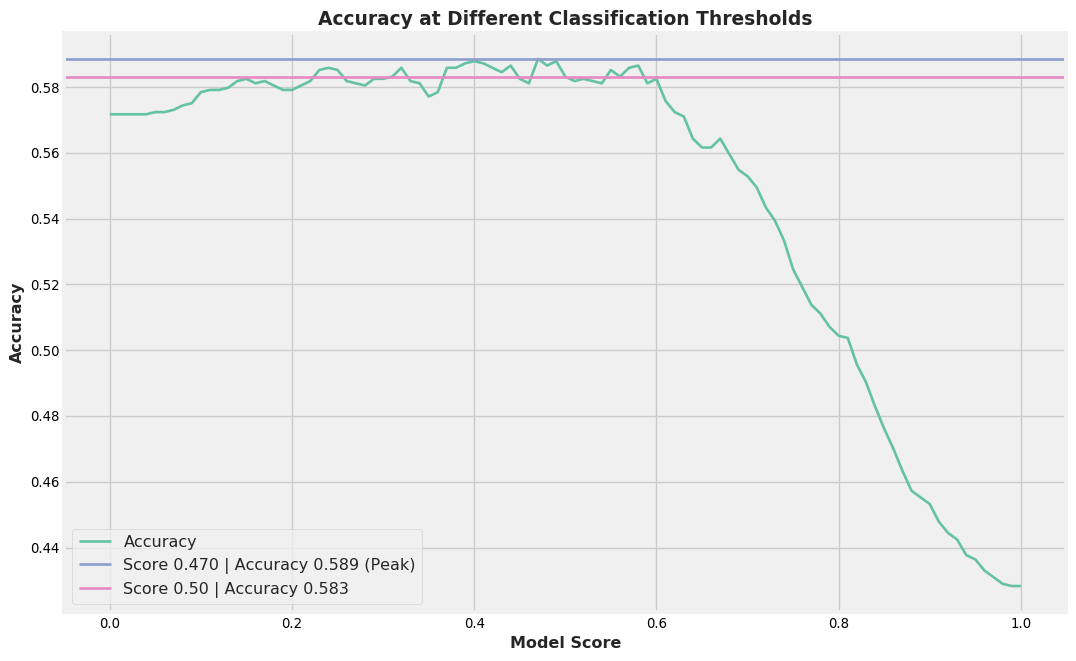

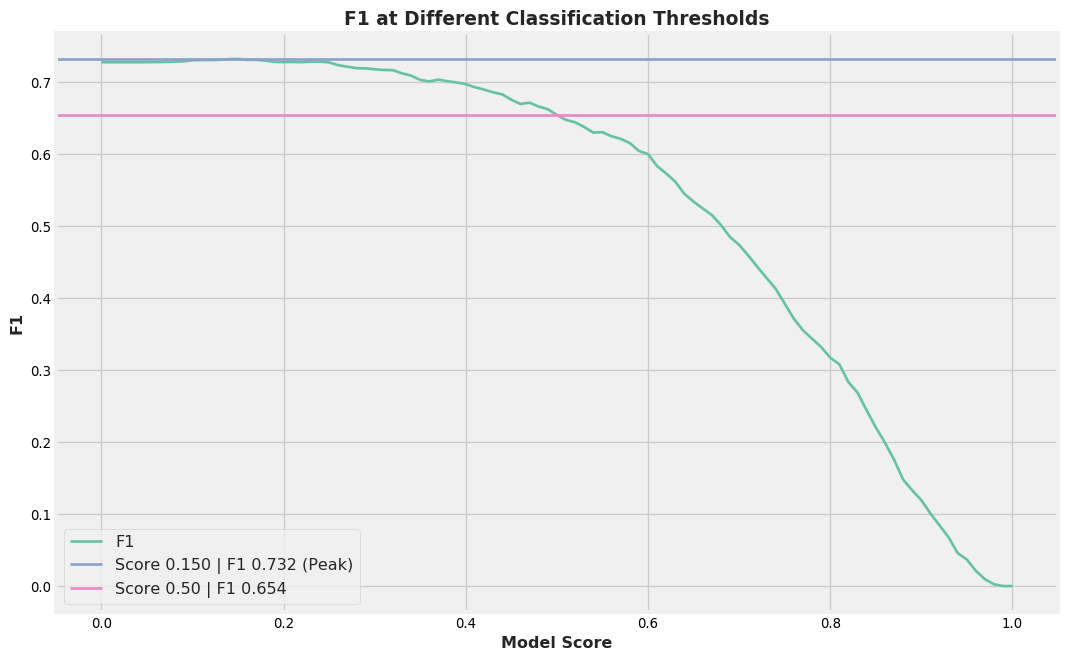

In [16]:
plot_by_threshold(scores_df, 'Accuracy')
plot_by_threshold(scores_df, 'F1')

#### Plot distributions

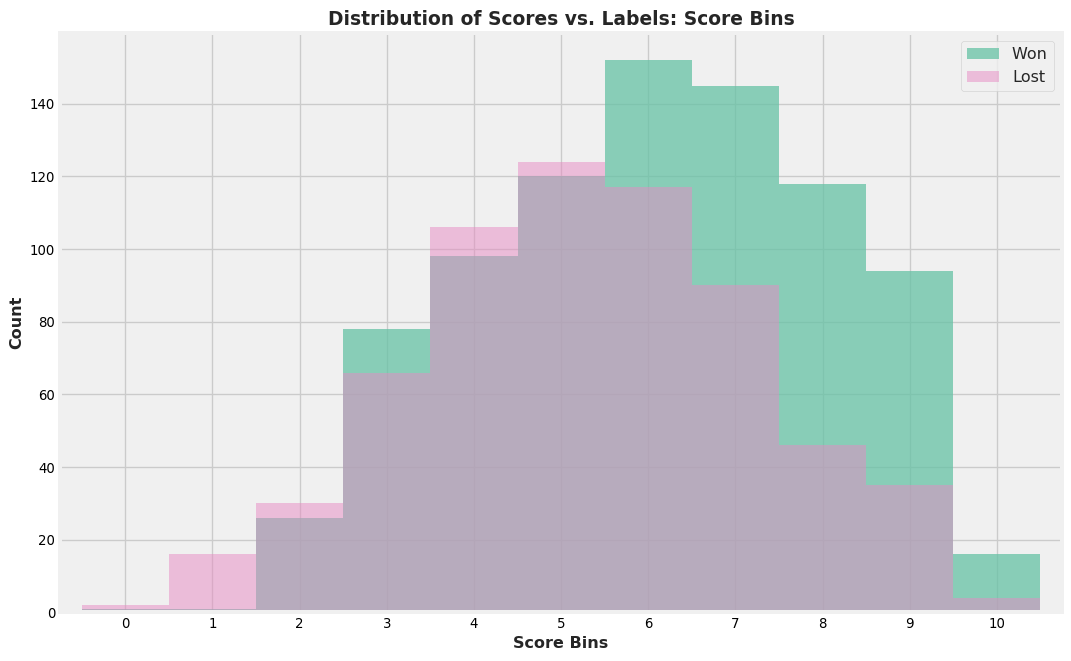

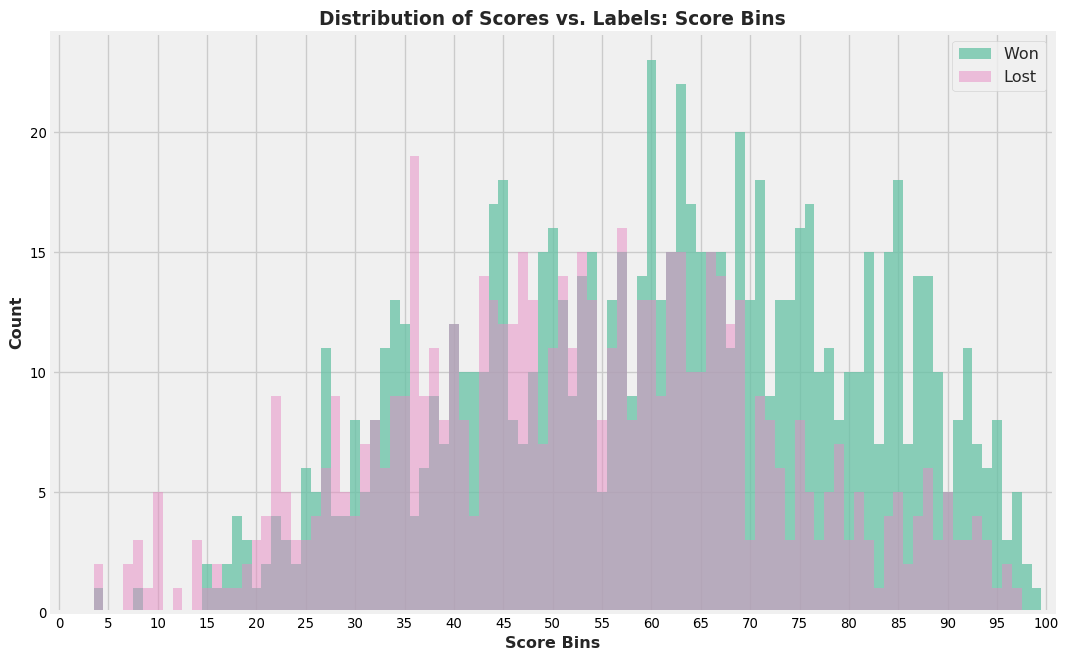

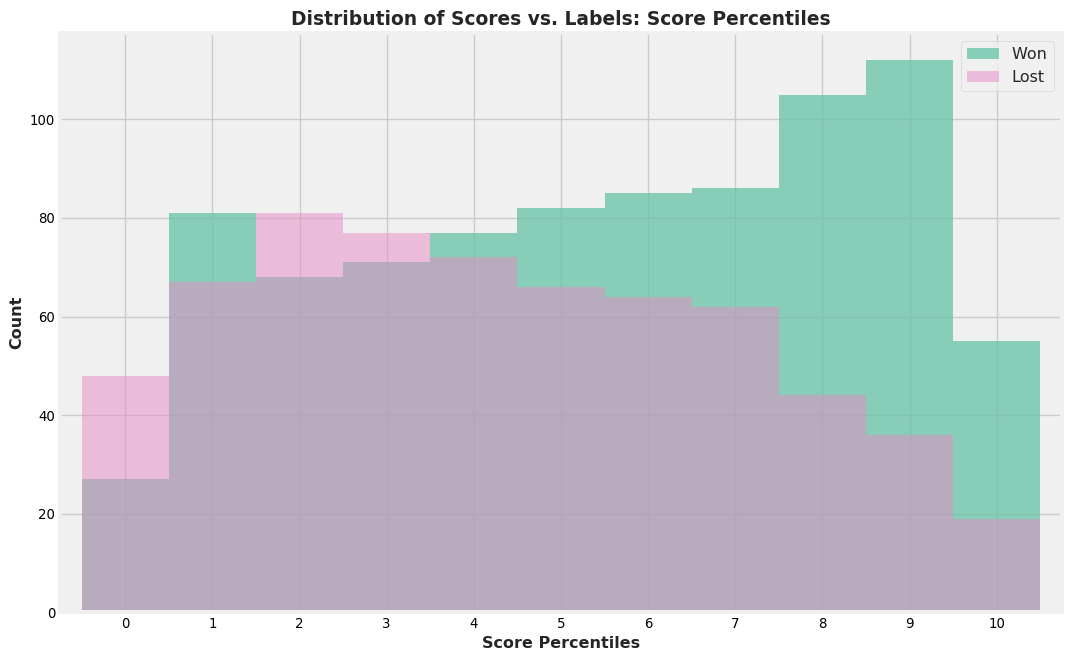

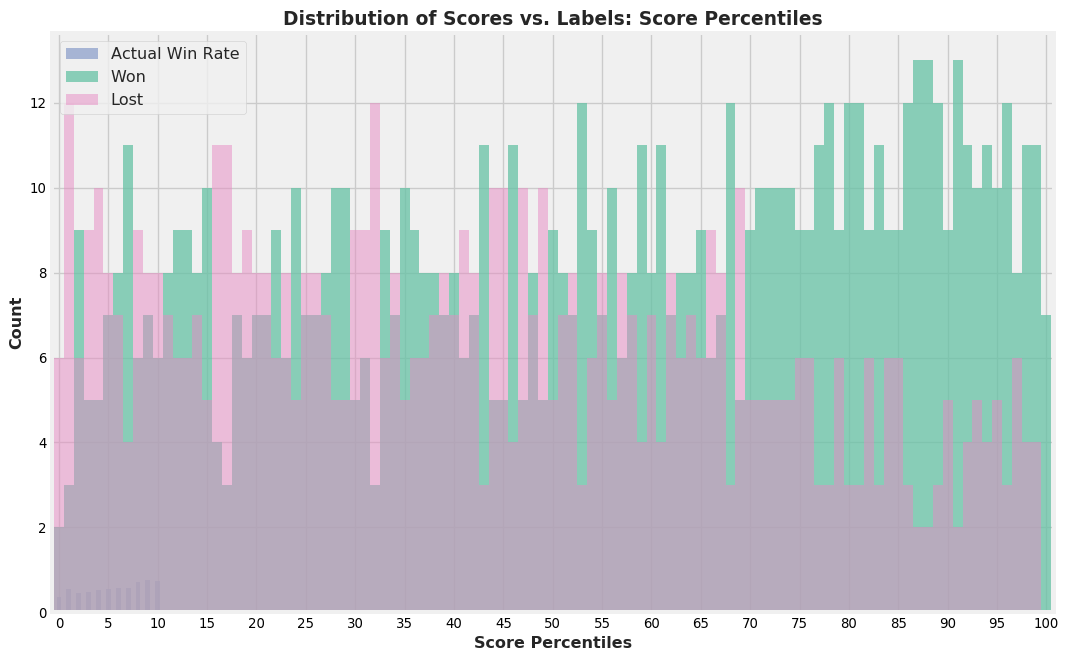

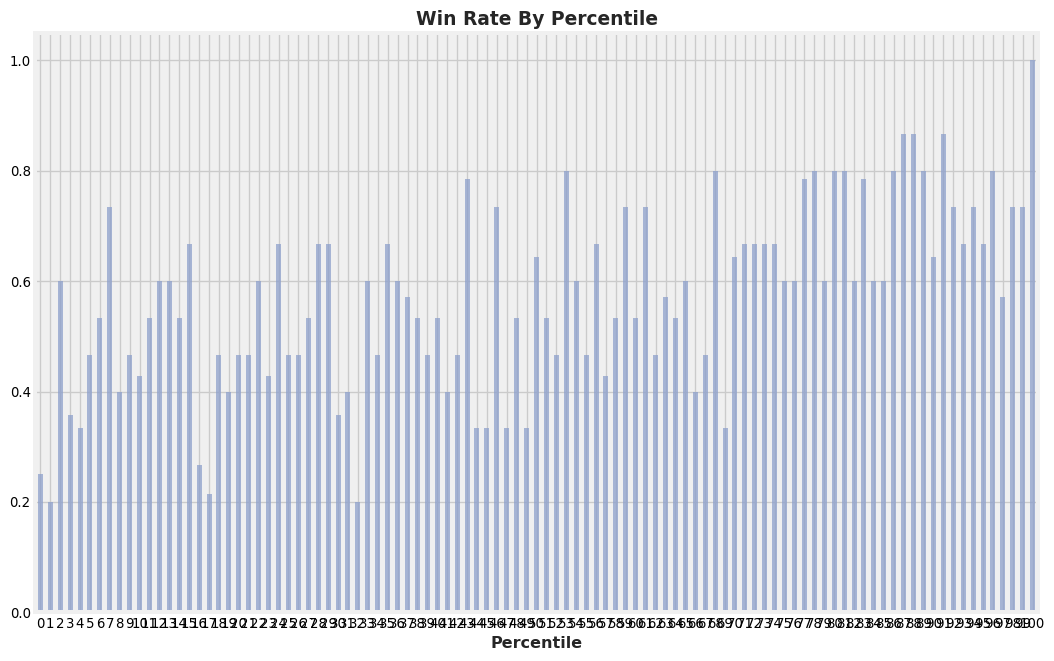

In [74]:
binned_data = {}
for bin_type in plots_dict['bin_types']:
    binned_data[bin_type] = {}
    for nbins in plots_dict['plot_bins']:
        ## plot bins
        curr_bins = compute_bins(plots_dict, scores_df, nbins, bin_type)
        compute_plot_bins(plots_dict, curr_bins, nbins, bin_type, colors)
        ## plot trend
        if bin_type == 'Percentile':
            plot_trend(plots_dict, curr_bins, bin_type, nbins)
        ## store data
        binned_data[bin_type][nbins] = curr_bins

#### Plot distributions

In [18]:
# ## TODO: store/load this
# training_scoring_dict

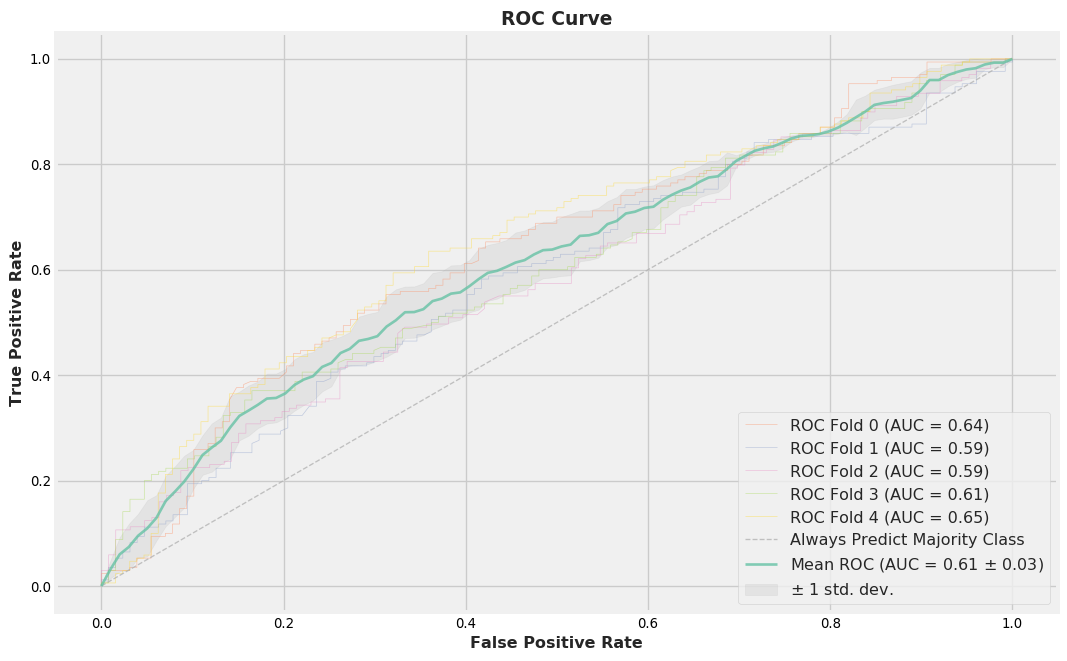

In [19]:
#### ROC
roc_sets = {
    set_nbr: set_data['score'][['label','score']]
    for set_nbr, set_data in training_scoring_dict.iteritems()
    if (set_data['score'].shape[0] > 0) 
       & (set_nbr in training_scoring_dict.keys())
}

roc_plot_kfold_errband(roc_sets)

In [22]:
training_scoring_dict.keys()

[0, 1, 2, 3, 4, 'full']

In [34]:
tmp = scores_df.copy()
tmp.loc['200811090mia', 'fold'] = None

tmp['fold'].unique()

array([nan,  0.,  1.,  2.,  3.,  4.])